In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
csv_url = r"C:\Users\GIA BAO\OneDrive - Trường ĐH CNTT - University of Information Technology\VCB-doan.csv"

In [3]:
data = pd.read_csv(csv_url, delimiter=';')
print(data)

            Date  Close   Open   High    Low    Vol  Change
0     07/12/2017  36089  36392  36392  35407  3.49M  -0.83%
1     08/12/2017  35672  36089  36089  35255  1.94M  -1.16%
2     11/12/2017  33815  34876  35558  33815  1.85M  -5.21%
3     12/12/2017  33891  34345  34421  31540  3.11M   0.22%
4     13/12/2017  33360  34118  34194  33132  1.50M  -1.57%
...          ...    ...    ...    ...    ...    ...     ...
1504  15/12/2023  82200  84000  84400  82200  2.53M  -2.61%
1505  18/12/2023  81500  82800  82900  81500  1.80M  -0.85%
1506  19/12/2023  81200  81500  81500  80100  1.96M  -0.37%
1507  20/12/2023  81100  81200  81300  80500  1.87M  -0.12%
1508  21/12/2023  80900  81000  81000  80300  2.03M  -0.25%

[1509 rows x 7 columns]


In [4]:
# Convert the 'Date' column to datetime with the correct format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

In [5]:
# Convert the data type of the 'Vol' and 'Change' columns
data['Vol'] = data['Vol'].str.replace('M', '').str.replace('K', '').astype(float)  # Convert 'M' to million and change the data type to float
data['Change'] = data['Change'].str.rstrip('%').astype(float) / 100.0  # Convert percentage to decimal number
print(data)

            Close   Open   High    Low   Vol  Change
Date                                                
2017-12-07  36089  36392  36392  35407  3.49 -0.0083
2017-12-08  35672  36089  36089  35255  1.94 -0.0116
2017-12-11  33815  34876  35558  33815  1.85 -0.0521
2017-12-12  33891  34345  34421  31540  3.11  0.0022
2017-12-13  33360  34118  34194  33132  1.50 -0.0157
...           ...    ...    ...    ...   ...     ...
2023-12-15  82200  84000  84400  82200  2.53 -0.0261
2023-12-18  81500  82800  82900  81500  1.80 -0.0085
2023-12-19  81200  81500  81500  80100  1.96 -0.0037
2023-12-20  81100  81200  81300  80500  1.87 -0.0012
2023-12-21  80900  81000  81000  80300  2.03 -0.0025

[1509 rows x 6 columns]


In [6]:
#Divide the data into Train-Test-Val sets with different ratios
def split_data(df, ratio):
    train, test_val = train_test_split(df, test_size=(1 - ratio[0]), shuffle=False)
    test, val = train_test_split(test_val, test_size=(ratio[2] / (ratio[1] + ratio[2])), shuffle=False)
    return train, test, val

#Ratio 7:2:1
train_data, test_data, val_data = split_data(data, [0.7, 0.2, 0.1])

In [7]:
features = ['Open', 'High', 'Low', 'Vol']
target = 'Close'
X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]
X_val, y_val = val_data[features], val_data[target]

In [8]:
#Training an SVR (Support Vector Regression) model
model = SVR(kernel='rbf')
model.fit(X_train, y_train)

SVR()

In [9]:
#Evaluate the model on various datasets
def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100

    print(f"{name} RMSE: {rmse:.2f}")
    print(f"{name} MAE: {mae:.2f}")
    print(f"{name} MAPE: {mape:.2f}")

#Evaluate the model on Train datasets 
evaluate_model(model, X_train, y_train, "Train")

#Evaluate the model on Test datasets 
evaluate_model(model, X_test, y_test, "Test")

#Evaluate the model on Val datasets 
evaluate_model(model, X_val, y_val, "Val")

Train RMSE: 13640.82
Train MAE: 11650.28
Train MAPE: 21.08
Test RMSE: 19403.60
Test MAE: 17976.97
Test MAPE: 21.44
Val RMSE: 28369.63
Val MAE: 27585.74
Val MAPE: 29.95


In [10]:
# Ensure last_data is defined
last_data = data.index[-1].strftime('%Y-%m-%d')

# Create X_next_30_days DataFrame
next_30_days = pd.date_range(last_data, periods=30, freq='B')
X_next_30_days = pd.DataFrame(index=next_30_days, columns=features)

# Make predictions for train, test, and val sets
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

# Make predictions for the next 30 days
last_data = data.index[-1].strftime('%Y-%m-%d')
last_data = pd.to_datetime(last_data) + pd.DateOffset(days=1)
next_30_days = pd.date_range(last_data, periods=30, freq='B')
X_next_30_days = X_next_30_days.fillna(0)
y_next_30_days = model.predict(X_next_30_days)

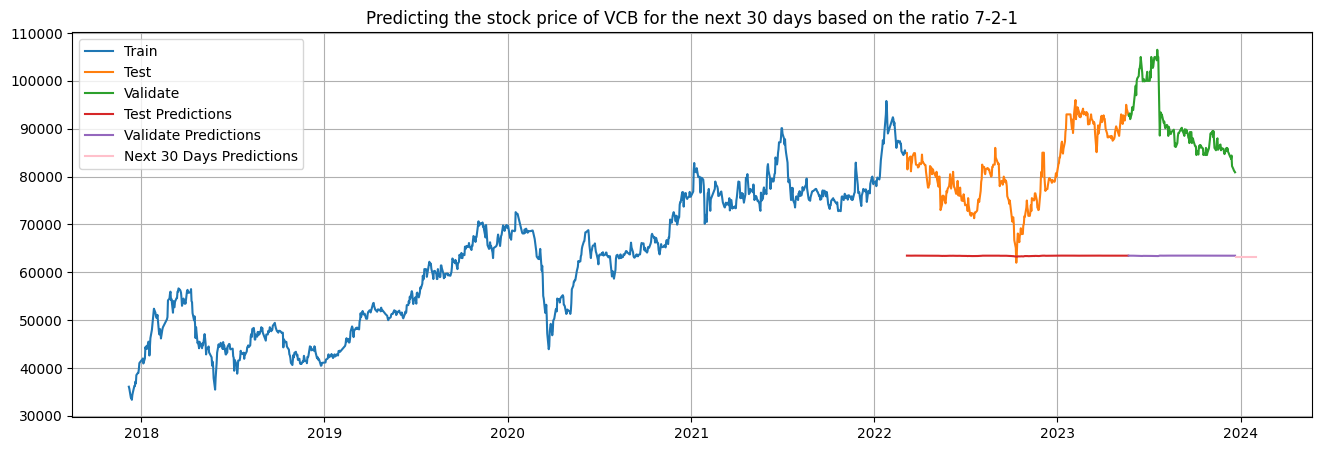

In [12]:
# Drawing plot
plt.figure(figsize=(16, 5))
plt.title("Predicting the stock price of VCB for the next 30 days based on the ratio 7-2-1")
plt.grid(True)
plt.plot(train_data.index, y_train, label='Train')
plt.plot(test_data.index, y_test, label='Test')
plt.plot(val_data.index, y_val, label='Validate')
plt.plot(test_data.index, y_pred_test, label='Test Predictions')
plt.plot(val_data.index, y_pred_val, label='Validate Predictions')
plt.plot(next_30_days, y_next_30_days, color="pink", label='Next 30 Days Predictions')
plt.legend()
plt.show()